# Image Segmentation with U-Net


<a name='1'></a>
## 1 - Packages

Importing all the required libraries.

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate



<a name='2'></a>
## 2 - Load and Split the Data

In [2]:
import os
import numpy as np 
import pandas as pd

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)

image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]


### Checking out  some of the unmasked and masked images from the dataset:

Text(0.5, 1.0, 'Segmentation')

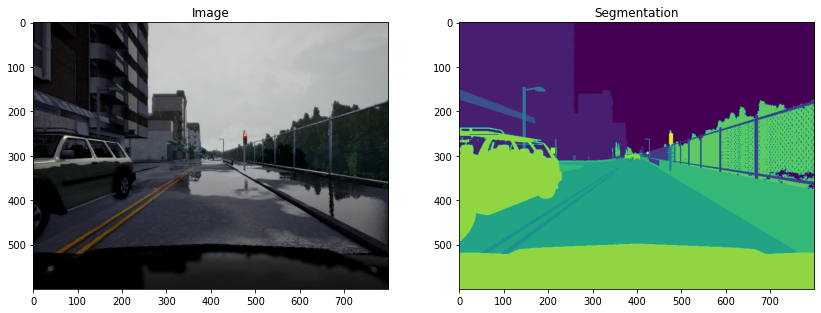

In [3]:
N = 5
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='2-1'></a>
### 2.1 - Split the Dataset into Unmasked and Masked Images

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\02_00_000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\02_00_001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\02_00_002.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\02_00_002.png'>)


<a name='2-2'></a>
### 2.2 - Split the Dataset into train and test dataset

In [4]:

image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)
    
train_size = int(0.8 * 5000)
test_size = int(0.2 * 5000)
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
    

tf.Tensor(b'./data/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/02_00_000.png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.3 - Preprocessing the Data

Read an image and its mask from their paths.

Convert the digital image and its mask to image arrays.

Resize the image and its masks to a desired dimension.

In [6]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)#Convert the digital image and its mask to image arrays
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

train_image_ds = train_ds.map(process_path)
test_image_ds = test_ds.map(process_path)
train_processed_image_ds = train_image_ds.map(preprocess)
test_processed_image_ds = test_image_ds.map(preprocess)




<a name='3'></a>
## 3 - U-Net 

<a name='3-1'></a>
### 3.1 - Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 1 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. Cropping is performed to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, using 1x1 convolutions can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, one can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total. 

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations.

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  



<a name='ex-1'></a>
### conv_block

Implementing `conv_block(...)`. 

* Adding 2 **Conv2D** layers with `n_filters` filters with `kernel_size` set to 3, `kernel_initializer` set to 'he_normal', `padding` set to 'same' and 'relu' activation.
* if `dropout_prob` > 0, then add a Dropout layer with parameter `dropout_prob`
* If `max_pooling` is set to True, then add a MaxPooling2D layer with 2x2 pool size

In [7]:

def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """


    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = BatchNormalization()(conv)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2, 2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [8]:
# Function to print summary of the model#

def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        result.append(descriptors)
    return result

<a name='ex-1'></a>
### summary of one conv_block

In [9]:
#summary of one conv_block#

input_size=(96, 128, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)
print('Block 1:')
for layer in summary(model1):
    print(layer)



Block 1:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal']
['BatchNormalization', (None, 96, 128, 32), 128]
['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal']
['BatchNormalization', (None, 96, 128, 32), 128]
['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]


<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. 

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

The `Conv2DTranspose` layer performs the inverse of the `Conv2D` layer.


<a name='ex-2'></a>
### upsampling_block

Implementing `upsampling_block(...)`.

For the function `upsampling_block`: 
* Takes the arguments `expansive_input` (which is the input tensor from the previous layer) and `contractive_input` (the input tensor from the previous skip layer)
* The number of filters here is the same as in the downsampling block you completed previously
* The `Conv2DTranspose` layer will take `n_filters` with shape (3,3) and a stride of (2,2), with padding set to `same`. It's applied to `expansive_input`, or the input tensor from the previous layer. 


* Concatenating the Conv2DTranspose layer output to the contractive input.

For the final component, set the parameters for two Conv2D layers to the same values that are set for the two Conv2D layers in the encoder (ReLU activation, He normal initializer, `same` padding). 


In [10]:

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
 
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = BatchNormalization()(conv)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    
    return conv

<a name='ex-1'></a>
### summary of one upsampling_block

In [11]:
# summary of one upsampling_block #

input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)


print('Block 1:')
for layer in summary(model1):
    print(layer)



Block 1:
['InputLayer', [(None, 12, 16, 256)], 0]
['Conv2DTranspose', (None, 24, 32, 32), 73760]
['InputLayer', [(None, 24, 32, 128)], 0]
['Concatenate', (None, 24, 32, 160), 0]
['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal']
['BatchNormalization', (None, 24, 32, 32), 128]
['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']
['BatchNormalization', (None, 24, 32, 32), 128]


<a name='3-4'></a>
### 3.4 - Build the Model

Putting all together, by chaining the encoder, bottleneck, and decoder!

<a name='ex-3'></a>
### unet_model


In [12]:

def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=13):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    
    # Contracting Path (encoding)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=None) 

    # Expanding Path (decoding)
   
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Adding a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding = 'same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [13]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Check out the model summary below! 

In [14]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 96, 128, 32)  896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 96, 128, 32)  128         conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 96, 128, 32)  9248        batch_normalization_4[0][0]      
____________________________________________________________________________________________

<a name='3-6'></a>
### 3.6 - Loss Function

In semantic segmentation, we need as many masks as we have object classes. In this dataset, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. 

Sparse categorical crossentropy is used as loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when we are dealing with lots of classes.

In [15]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<a name='3-7'></a>
### 3.7 - Dataset Handling


In [16]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(600, 800, 1)


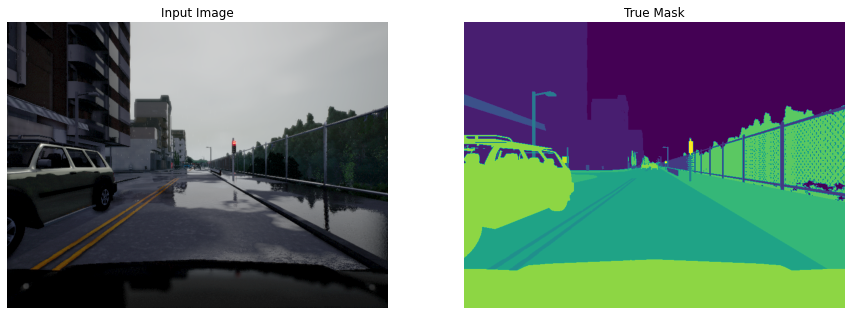

In [17]:
for image, mask in train_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


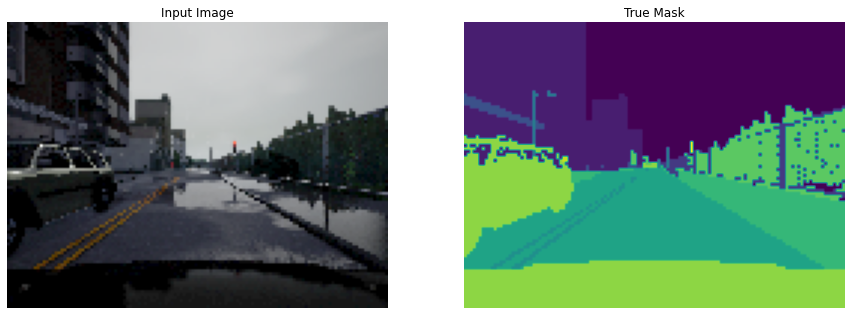

In [18]:
for image, mask in train_processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
## 4 - Train the Model

In [19]:
EPOCHS = 30
#VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_processed_image_ds.batch(BATCH_SIZE)
train_dataset = train_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/30
125/125 [==============================] - 33s 196ms/step - loss: 0.5596 - accuracy: 0.8372
Epoch 2/30
125/125 [==============================] - 18s 147ms/step - loss: 0.2803 - accuracy: 0.9149
Epoch 3/30
125/125 [==============================] - 18s 147ms/step - loss: 0.2287 - accuracy: 0.9300
Epoch 4/30
125/125 [==============================] - 18s 147ms/step - loss: 0.2064 - accuracy: 0.9365
Epoch 5/30
125/125 [==============================] - 18s 147ms/step - loss: 0.1862 - accuracy: 0.9424
Epoch 6/30
125/125 [==============================] - 19s 148ms/step - loss: 0.1676 - accuracy: 0.9475
Epoch 7/30
125/125 [==============================] - 19s 148ms/step - loss: 0.1502 - accuracy: 0.9526
Epoch 8/30
125/125 [==============================] - 19s 149ms/step - loss: 0.1354 - accuracy: 0.9568
Epoch 9/30
125/125 [==============================] - 1

<a name='4'></a>
## Model Evaluation

In [20]:
#unet.evaluate(test_processed_image_ds)
test_dataset=test_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(32)
test_loss, test_accuracy = unet.evaluate(test_dataset)


32/32 [==============================] - 5s 100ms/step - loss: 0.2738 - accuracy: 0.9394


<a name='4-1'></a>
### 4.1 - Create Predicted Masks 

Now, defining a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [21]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy



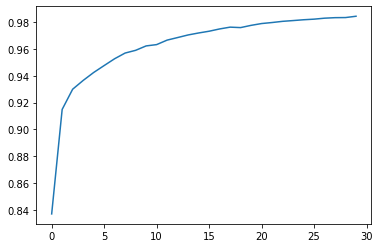

In [22]:
plt.plot(model_history.history["accuracy"])

<a name='4-3'></a>
### 4.3 - Show Predictions 

Next, checking the predicted masks against the true mask and the original input image:

In [23]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

<a name='4-3'></a>
###  Predict and compare masks of images in the training set 

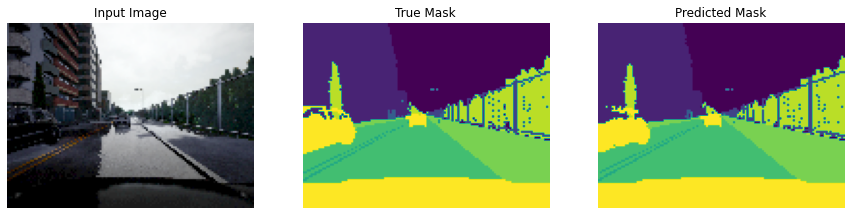

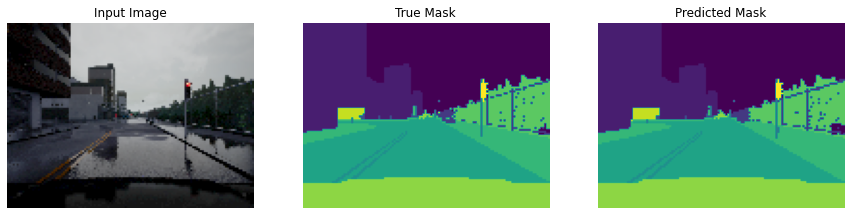

In [32]:
show_predictions(train_dataset, 2)

<a name='4-3'></a>
###  Predict and compare masks of images in the test set 

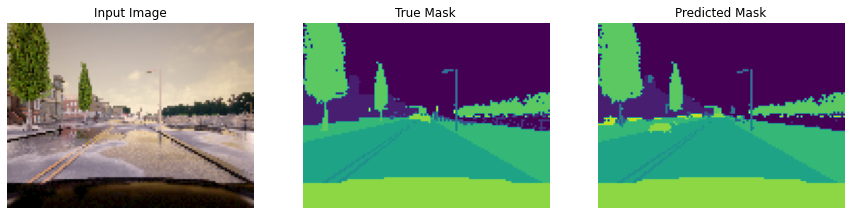

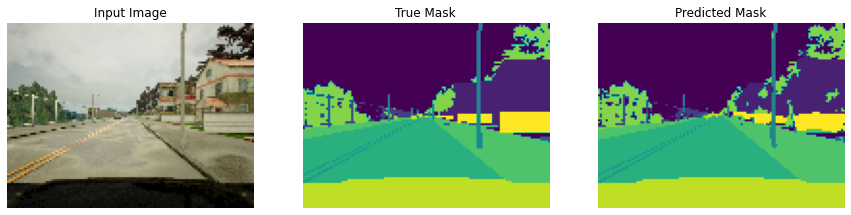

In [31]:
show_predictions(test_dataset, 2)
